In [1]:
from gym import Env
import gym
import pygame
from gym.spaces import Discrete, Box,Dict
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
np.set_printoptions(linewidth=500,threshold=np.inf)

## Environment AirTraffic

In [2]:
class AirTraffic():
    def __init__(self,planes:int = 2, grid_size:list = [5,5],radius:int = 2,seed = None,destinations:int =None ):
        self.radius = radius
        self.planes = planes
        self.destinations = destinations
        self.GRID_DIM = grid_size
        self.seed = seed
        self._max_dist = np.sqrt(self.GRID_DIM[0]**2 + self.GRID_DIM[1]**2)
        self._action_to_direction = {
            0: np.array([-1, 0]),
            1: np.array([-1, 1]),
            2: np.array([0,  1]),
            3: np.array([-1 , -1]),
            4: np.array([0 , -1]),
            
        }        
    
        self._ACTIONLOOKUP = {
            0: 'Up',
            1: 'front right',
            2: 'right',
            3: 'front left',
            4: 'left'
            }
        self.GRID_DIM = np.array(self.GRID_DIM)
        self.GRID = np.zeros(self.GRID_DIM)
        self.action_space = Discrete(len(self._ACTIONLOOKUP.keys()))
        self.state_space = Discrete(self.GRID_DIM[0]*self.GRID_DIM[1])
        self._ob_space = {}
        for p in range(self.planes):
            self._ob_space[f'plane{p}'] = Box(np.array([0,0]), np.array([self.GRID_DIM[0]-1,self.GRID_DIM[1] - 1]), shape=(2,), dtype=int)
            self._ob_space[f'dest{p}'] = Box(np.array([0,0]), np.array([self.GRID_DIM[0]-1,self.GRID_DIM[1] - 1]), shape=(2,), dtype=int)
        
        self.observation_space = Dict(self._ob_space)
        self._agent_location = []
        self._target_location = []
        # Randomly initialize the start points of planes and destinations
        if self.seed is not None:
            np.random.seed(seed = seed)
        for p in range(self.planes):
            while (pc:= [np.random.randint(self.GRID_DIM[0]),np.random.randint(self.GRID_DIM[1])]) in self._agent_location:
                continue
            self._agent_location.append(pc)
            if self.destinations is None:
                while (dc:=[np.random.randint(self.GRID_DIM[0]),np.random.randint(self.GRID_DIM[1])]) in self._agent_location + self._target_location:
                    continue
                self._target_location.append(dc)
        if self.destinations is not None:
            for d in range(self.destinations):
                while (dc:=[np.random.randint(self.GRID_DIM[0]),np.random.randint(self.GRID_DIM[1])]) in self._agent_location + self._target_location:
                    continue
                self._target_location.append(dc)
        
            extra = np.random.choice(range(len(self._target_location)),self.planes-self.destinations)
            for d in extra:
                self._target_location.append(self._target_location[d])
        self._agent_location = np.array(self._agent_location)
        self._target_location = np.array(self._target_location)
#         print(self._target_location)
        self._count = [0]*self.planes # to check if its already landed/reached destination

    def step(self,action):
        self._prev_agent_location = [None]*self.planes
        moved_plane = [False]*self.planes

#             for plane,action in enumerate(action): 
        moved_plane = self._move(action)
        done,reward =  self._is_over()
        observation = self._get_obs()
        info = self._get_info()
        return observation, reward, done, info
    def _move(self, action):
         ##### Find the vector of agent from destination to find 
        ### reward of terminal state for a plane is _todestination and that plane cant move now
        self._prev_agent_location = self._agent_location
        for plane,act in enumerate(action):
            if np.array_equal(self._agent_location[plane],self._target_location[plane]):
                self._count[plane]+=1
                continue
            elif np.sign(self._target_location[plane]-self._prev_agent_location[plane])[0]<=0:
                self._agent_location[plane] = np.clip(self._agent_location[plane] + self._action_to_direction[act],[0,0],[self.GRID_DIM[0] - 1, self.GRID_DIM[1] - 1])
            else: 
                self._agent_location[plane] = np.clip(self._agent_location[plane] + -1*self._action_to_direction[act],[0,0],[self.GRID_DIM[0] - 1, self.GRID_DIM[1] - 1])

        return   self._prev_agent_location== self._agent_location
    def _is_over(self):
        done = (self._agent_location==self._target_location).all(axis = 1)
        reward = self._get_reward()
        return done, reward
    def _get_reward(self):
        reward = []
        # reward will be the either of intruder or todestination
        distance, closest_dist = self._get_info()
        for index,plane in enumerate(range(self.planes)):
            if self._count[plane] >0:
                reward.append(self._max_dist)##### Reward of completion 
            elif closest_dist[plane] <self.radius:
                self._intruder = -(self.radius **2 - closest_dist[plane]**2)/(self.radius**2/500)
                reward.append(self._intruder)
#                 print(closest_dist[plane])
            else:
                self._todestination = self._max_dist - distance[plane] # max_dist is the max distance possible from any plane to its destination
                reward.append(self._todestination)
        return reward
    def _get_obs(self):
        return {'planes': self._agent_location,'destinations':self._target_location}
    def _get_info(self):
        closest_dist = []
        distance = []
        for index,plane in enumerate(range(self.planes)):
            dist = np.linalg.norm([self._agent_location[plane]]*self.planes-self._agent_location,axis = 1)
            if np.argmin(dist) == plane :
                dist[plane] = np.inf
            closest_dist .append(np.min(dist))
#             self._intruder = -(self.radius **2 - closest_dist**2)/(self.radius**2/500)
            distance .append(np.linalg.norm(self._target_location[plane]-self._agent_location[plane]))
#             print(self._intruder,self._todestination)
        return distance,closest_dist
    def _state_in_seq(self):
        seq = []
        for plane in self._agent_location:
            m, n = plane
            seq.append(m * self.GRID.shape[1] + n)
            
        return seq
    def render(self):
        rend = self.GRID.copy().astype(dtype = 'U2')
        for plane in range(self.planes):
            rend[self._agent_location[plane][0],self._agent_location[plane][1]] = f'p{plane}'
            rend[self._target_location[plane][0],self._target_location[plane][1]] = f'd{plane}'
        return print(rend) 
    def reset(self):
        self._agent_location = []
        self._target_location = []
        if self.seed is not None:
            np.random.seed(seed = self.seed)
        for p in range(self.planes):
            while (pc:= [np.random.randint(self.GRID_DIM[0]),np.random.randint(self.GRID_DIM[1])]) in self._agent_location:
                continue
            self._agent_location.append(pc)
            while (dc:=[np.random.randint(self.GRID_DIM[0]),np.random.randint(self.GRID_DIM[1])]) in self._agent_location + self._target_location:
                continue
            self._target_location.append(dc)
        self._agent_location = np.array(self._agent_location)
        self._target_location = np.array(self._target_location)
        self._count = [0]*self.planes


In [3]:
env = AirTraffic(destinations=1)
env.render()

[['0.' '0.' '0.' '0.' '0.']
 ['0.' '0.' '0.' '0.' 'p1']
 ['0.' '0.' '0.' '0.' 'd1']
 ['0.' '0.' '0.' 'p0' '0.']
 ['0.' '0.' '0.' '0.' '0.']]


## Random Policy Agent

In [4]:
def random_policy(env,episodes):
    action_space ={
        0: np.array([-1, 0]),
        1: np.array([-1, 1]),
        2: np.array([0,  1]),
        3: np.array([-1 , -1]),
        4: np.array([0 , -1]),            
    }
    timestep_reward = []
    cumsum_reward  = []
    max_step=100
    for ep in range(episodes):
        env.reset()
#         print(env._get_obs())
        done =  [False]*env.planes
        total_reward = [0]*env.planes
        cumsum_ep= []
        t=0
        while not np.array(done).all() and t<max_step:
            
            action = []
            distance, closest_dist = env._get_info()
            for plane in range(env.planes):
                if closest_dist[plane]< env.radius:
                    action.append(np.random.randint(env.action_space.n))
                else:
                    x = np.sign(env._target_location[plane] - env._agent_location[plane])
                    if x[0] in [0,-1]:
                        for act,a in enumerate(action_space.values()):
                            _ = np.array_equal(x,a)
                            if _:
#                                 print(_)
                                action.append(act)
                                break
                    else:
                        x = -x
                        for act,a in enumerate(action_space.values()):
                            _ = np.array_equal(x,a)
                            if _:
                                action.append(act)
                                break
            t+=1
            obs,reward,done,info  = env.step(action)
            total_reward= np.add(total_reward,reward)
        cumsum_reward.append(total_reward/t)
        timestep_reward.append(total_reward)
            
    return timestep_reward,cumsum_reward            

In [5]:
# env = AirTraffic(planes=25,grid_size=[100,100],radius=50,destinations=1)
env = AirTraffic(planes=3,grid_size = [20,20],destinations=1)
episodes = 300
timestep_reward,cumsum_reward_rand = random_policy(env,episodes)

Text(0, 0.5, 'Average Score')

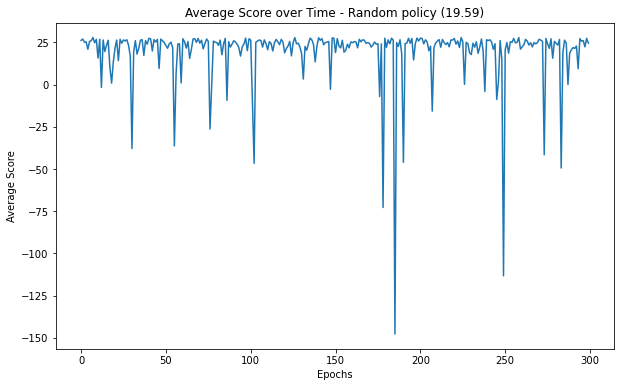

In [6]:
cumsum_plane_avg_rand = np.average(cumsum_reward_rand,axis=1)
plt.figure(figsize = (10,6))
plt.title(label=f'Average Score over Time - Random policy ({np.average(cumsum_plane_avg_rand) :.2f})')
plt.plot(cumsum_plane_avg_rand)
plt.xlabel('Epochs')
plt.ylabel(f'Average Score')
# plt.semilogy()

## Greedy Policy Agent

In [7]:
def greedy_policy(env,episodes):
    action_space ={
        0: np.array([-1, 0]),
        1: np.array([-1, 1]),
        2: np.array([0,  1]),
        3: np.array([-1 , -1]),
        4: np.array([0 , -1]),            
    }
    timestep_reward = []
    cumsum_reward  = []
    max_step=100
    for ep in range(episodes):
        env.reset()
#         print(env._get_obs())
        done =  [False]*env.planes
        total_reward = [0]*env.planes
        cumsum_ep= []
        t=0
        while not np.array(done).all() and t<max_step:
            
            action = []
            for plane in range(env.planes):
                x = np.sign(env._target_location[plane] - env._agent_location[plane])
                if x[0] in [0,-1]:
                    for act,a in enumerate(action_space.values()):
                        _ = np.array_equal(x,a)
                        if _:
    #                                 print(_)
                            action.append(act)
                            break
                else:
                    x = -x
                    for act,a in enumerate(action_space.values()):
                        _ = np.array_equal(x,a)
                        if _:
                            action.append(act)
                            break
            t+=1
            obs,reward,done,info  = env.step(action)
            total_reward= np.add(total_reward,reward)
        cumsum_reward.append(total_reward/t)
        timestep_reward.append(total_reward)
            
    return timestep_reward,cumsum_reward            

In [8]:
# env = AirTraffic(planes=25,grid_size=[100,100],radius=50,destinations=1)
env = AirTraffic(planes=3,grid_size=[20,20],destinations=1)
episodes = 300
timestep_reward,cumsum_reward_greed = greedy_policy(env,episodes)

Text(0, 0.5, 'Average Score')

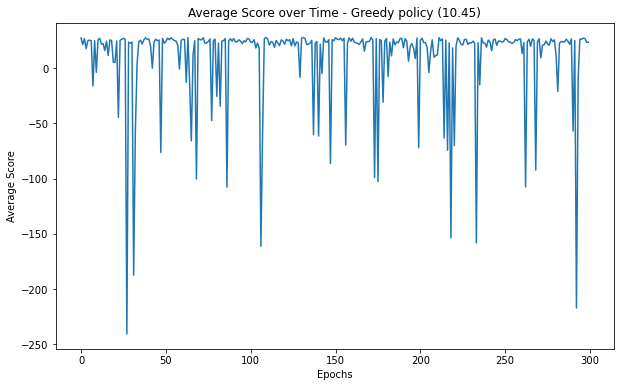

In [9]:
cumsum_plane_avg_greed = np.average(cumsum_reward_greed,axis=1)
plt.figure(figsize = (10,6))
plt.title(label=f'Average Score over Time - Greedy policy ({np.average(cumsum_plane_avg_greed) :.2f})')
plt.plot(cumsum_plane_avg_greed)
plt.xlabel('Epochs')
plt.ylabel(f'Average Score')

## Multi-Agent SARSA

In [14]:
def ep_greedy(env,Q,count_state,epsilon=0.1):
    seqs = env._state_in_seq()
    action = []
    for plane,seq in enumerate(seqs):
        if np.random.random()>epsilon:
            x=(count_state[plane,seq,:]!=0).all()
            if x :           
                action.append(np.argmax(Q[plane,seq,:]))
            else:
                axn = np.where(Q[plane,seq,:]==0)[0]
                action.append(axn[0])
        else:
            action.append(np.random.randint(env.action_space.n))
    return action


def Sarsa(env,alpha, gamma, epsilon, episodes,temperature=None):
    timestep_reward = []
    cumsum_reward  = []
    count_state = np.zeros_like(Q)
    for ep in range(episodes):
        env.reset()
        done = [False]*env.planes
        total_reward = [0]*env.planes
        cumsum_ep= []
        curr_state = env._state_in_seq()
        curr_a = ep_greedy(env,Q,epsilon=epsilon,count_state=count_state)
        t = 0
        while not np.array(done).all() :
            for plane,seq in enumerate(curr_state):
                count_state[plane,seq,curr_a[plane]]+=1
            obs, reward, done, info = env.step(curr_a)
            next_state = env._state_in_seq()
            total_reward= np.add(total_reward,reward)
            next_act = ep_greedy(env,Q,epsilon=epsilon,count_state=count_state)
            t+=1
            
            for plane in range(env.planes):
                Q[plane,curr_state[plane], curr_a[plane]] += alpha * ( reward[plane] + (gamma * Q[plane,next_state[plane], next_act[plane]] ) - Q[plane,curr_state[plane], curr_a[plane]] )
            curr_state = next_state
            curr_a = next_act
            print(t,ep,end=' ')
            clear_output(wait=True)
        cumsum_reward.append(total_reward/t)
        timestep_reward.append(total_reward)
        if temperature is not None and ep%temperature==0:
            epsilon = 0.9*epsilon
            print(epsilon)
        
    clear_output()
    return timestep_reward,cumsum_reward

### Single Destination Multiple Planes

#### Temperature Controlled Exploration

In [89]:
env = AirTraffic(planes=25,grid_size=[100,100],radius=50,destinations=1)
# env = AirTraffic(planes=3,grid_size=[20,20],radius=2)
n_planes,n_states, n_actions = env.planes, env.state_space.n, env.action_space.n
Q = np.zeros((n_planes, n_states, n_actions))
alpha = 0.5
gamma = 0.9
epsilon = 0.5
episodes = 150
temperature = 10
timestep_reward,cumsum_reward_temp = Sarsa(env,alpha, gamma, epsilon, episodes, temperature)

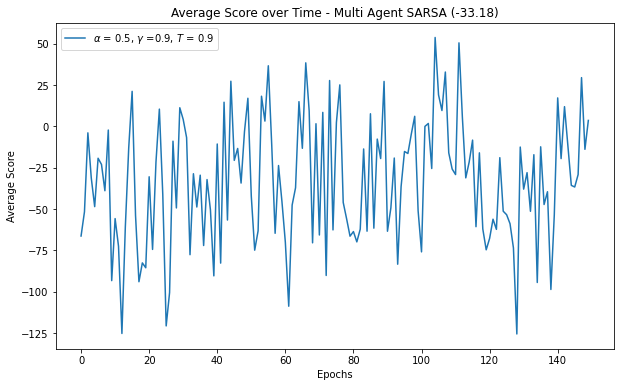

In [90]:
cumsum_plane_avg_temp = np.average(cumsum_reward_temp,axis=1)
plt.figure(figsize = (10,6))
plt.title(label=f'Average Score over Time - Multi Agent SARSA ({np.average(cumsum_plane_avg_temp) :.2f})')
plt.plot(cumsum_plane_avg_temp,label = r'$\alpha$ = ' +f'{alpha}, '+ r'$\gamma$ =' +f'{gamma}, '+r'$T$ = '+f'{1-1/temperature}')
plt.xlabel('Epochs')
plt.ylabel(f'Average Score')
plt.legend()

#### Constant Exploration Factor

In [ ]:
env = AirTraffic(planes=25,grid_size=[100,100],radius=50,destinations=1)
# env = AirTraffic(planes=3,grid_size=[5,5],radius=2,destinations=1)
n_planes,n_states, n_actions = env.planes, env.state_space.n, env.action_space.n
Q = np.zeros((n_planes, n_states, n_actions))
alpha = 0.5
gamma = 0.9
epsilon = 0.1
episodes = 150
timestep_reward,cumsum_reward_cnst = Sarsa(env,alpha, gamma, epsilon, episodes)

58869 1 

In [ ]:
cumsum_plane_avg_cnst = np.average(cumsum_reward_cnst,axis=1)
plt.figure(figsize = (10,6))
plt.title(label=f'Average Score over Time - Multi Agent SARSA, Single Destination ({np.average(cumsum_plane_avg_cnst) :.2f})')
plt.plot(cumsum_plane_avg_cnst,label = r'($\epsilon$ = '+ f'{epsilon},'+r'$\alpha$ = ' +f'{alpha}, '+ r'$\gamma$ =' +f'{gamma}')
plt.xlabel('Epochs')
plt.ylabel(f'Average Score')
plt.legend()

## Multi Destination Multi Agents

In [ ]:
env = AirTraffic(planes=25,grid_size=[100,100],radius=50)
# env = AirTraffic(planes=3,grid_size=[5,5],radius=2)
n_planes,n_states, n_actions = env.planes, env.state_space.n, env.action_space.n
Q = np.zeros((n_planes, n_states, n_actions))
alpha = 0.2
gamma = 0.9
epsilon = 0.1
episodes = 150
timestep_reward,cumsum_reward_multi = Sarsa(env,alpha, gamma, epsilon, episodes)

In [ ]:
cumsum_plane_avg_multi = np.average(cumsum_reward_multi,axis=1)
plt.figure(figsize = (10,6))
plt.title(label=f'Average Score over Time - Multi Agent SARSA, Multi Destination ({np.average(cumsum_plane_avg_multi) :.2f})')
plt.plot(cumsum_plane_avg_multi,label = r'($\epsilon$ = '+ f'{epsilon},'+r'$\alpha$ = ' +f'{alpha}, '+ r'$\gamma$ =' +f'{gamma}')
plt.xlabel('Epochs')
plt.ylabel(f'Average Score')
plt.legend()

In [ ]:
class AirTraffic():
    def __init__(self,planes:int = 2, grid_size:list = [5,5],radius:int = 2,seed = None,destinations:int =None ):
        self.radius = radius
        self.planes = planes
        self.destinations = destinations
        self.GRID_DIM = grid_size
        self.seed = seed
        self._max_dist = np.sqrt(self.GRID_DIM[0]**2 + self.GRID_DIM[1]**2)
        self._action_to_direction = {
            0: np.array([-1, 0]),
            1: np.array([-1, 1]),
            2: np.array([0,  1]),
            3: np.array([-1 , -1]),
            4: np.array([0 , -1]),
            
        }        
    
        self._ACTIONLOOKUP = {
            0: 'Up',
            1: 'front right',
            2: 'right',
            3: 'front left',
            4: 'left'
            }
        self.GRID_DIM = np.array(self.GRID_DIM)
        self.GRID = np.zeros(self.GRID_DIM)
        self.action_space = Discrete(len(self._ACTIONLOOKUP.keys()))
        self.state_space = Discrete(self.GRID_DIM[0]*self.GRID_DIM[1])
        self._ob_space = {}
        for p in range(self.planes):
            self._ob_space[f'plane{p}'] = Box(np.array([0,0]), np.array([self.GRID_DIM[0]-1,self.GRID_DIM[1] - 1]), shape=(2,), dtype=int)
            self._ob_space[f'dest{p}'] = Box(np.array([0,0]), np.array([self.GRID_DIM[0]-1,self.GRID_DIM[1] - 1]), shape=(2,), dtype=int)
        
        self.observation_space = Dict(self._ob_space)
        self._agent_location = []
        self._target_location = []
        # Randomly initialize the start points of planes and destinations
        if self.seed is not None:
            np.random.seed(seed = seed)
        for p in range(self.planes):
            while (pc:= [np.random.randint(self.GRID_DIM[0]),np.random.randint(self.GRID_DIM[1])]) in self._agent_location:
                continue
            self._agent_location.append(pc)
            if self.destinations is None:
                while (dc:=[np.random.randint(self.GRID_DIM[0]),np.random.randint(self.GRID_DIM[1])]) in self._agent_location + self._target_location:
                    continue
                self._target_location.append(dc)
        if self.destinations is not None:
            for d in range(self.destinations):
                while (dc:=[np.random.randint(self.GRID_DIM[0]),np.random.randint(self.GRID_DIM[1])]) in self._agent_location + self._target_location:
                    continue
                self._target_location.append(dc)
        
            extra = np.random.choice(range(len(self._target_location)),self.planes-self.destinations)
            for d in extra:
                self._target_location.append(self._target_location[d])
        self._agent_location = np.array(self._agent_location)
        self._target_location = np.array(self._target_location)
#         print(self._target_location)
        self._count = [0]*self.planes # to check if its already landed/reached destination
        self._done_prev = [False]*self.planes
        self._prev_agent_location = self._agent_location.copy()


    def step(self,action):
#         self._prev_agent_location = [None]*self.planes
        self._prev_agent_location = self._agent_location.copy()##### Find the vector of agent from destination to find ### reward of terminal state for a plane is 0 and that plane cant move now
        moved_plane = [False]*self.planes

#             for plane,action in enumerate(action): 
        moved_plane = self._move(action)
        done,reward =  self._is_over()
        observation = self._get_obs()
        info = self._get_info()
        self._done_prev = done.copy()
        return observation, reward, done, info
    def _move(self, action):
         ##### Find the vector of agent from destination to find 
        ### reward of terminal state for a plane is _todestination and that plane cant move now
        self._prev_agent_location = self._agent_location
        for plane,act in enumerate(action):
            if np.array_equal(self._agent_location[plane],self._target_location[plane]):
                self._count[plane]+=1
                continue
            elif np.sign(self._target_location[plane]-self._prev_agent_location[plane])[0]<=0:
                self._agent_location[plane] = np.clip(self._agent_location[plane] + self._action_to_direction[act],[0,0],[self.GRID_DIM[0] - 1, self.GRID_DIM[1] - 1])
            else: 
                self._agent_location[plane] = np.clip(self._agent_location[plane] + -1*self._action_to_direction[act],[0,0],[self.GRID_DIM[0] - 1, self.GRID_DIM[1] - 1])

        return   self._prev_agent_location== self._agent_location
    def _is_over(self):
        done = (self._agent_location==self._target_location).all(axis = 1)
        reward = self._get_reward()
        return done, reward
    def _get_reward(self):
        reward = []
        # reward will be the minimum of intruder and todestination
        distance, closest_dist ,_1,_2= self._get_info()
        for index,plane in enumerate(range(self.planes)):
            if self._count[plane] >0:
                reward.append(100)######## CHanged from 0 
            else:
                self._intruder = 0
                if closest_dist[plane] <self.radius:
                
#             closest_dist = np.min(np.linalg.norm([self._agent_location[plane]]*self.planes-self._agent_location,axis = 1))
                    self._intruder = -(self.radius **2 - closest_dist[plane]**2)/(self.radius**2/500) 
#                 reward.append(self._intruder)
#                 print(closest_dist[plane])
#             else:
                self._todestination = 100 - distance[plane]#np.linalg.norm(self._target_location[plane]-self._agent_location[plane])
                reward.append(self._todestination + self._intruder)
#             print(self._intruder,self._todestination)
#         print(reward)
#             reward.append(np.min([self._intruder,self._todestination]))
        return reward
    def _get_obs(self):
        return {'planes': self._agent_location,'destinations':self._target_location}
    def _get_info(self):
            closest_dist = []
            distance = []
    #         arg_plane = []
            plane_theta = []
            plane_rho = []
            dne= self._done_prev
            for index,plane in enumerate(range(self.planes)):
                dist = np.linalg.norm([self._agent_location[plane]]*self.planes-self._agent_location,axis = 1)
    #             if np.argmin(dist) == plane :
                dist[plane] = np.inf
                dist[dne] = np.inf
                if dne[plane]:
                    dist += np.inf
                    plane_rho.append(np.inf)
                    plane_theta.append(np.inf)
                    closest_dist .append(np.min(dist))
                else:
                    closest_dist .append(np.min(dist))
                    arg_plane = np.argmin(dist)

    #                 closest_dist[plane] = np.inf

    #             else:
                    if (self._prev_agent_location==None).all():
                        self._prev_agent_location = self._agent_location.copy()
                    ownship = self._agent_location[plane]-self._prev_agent_location[plane] 
                    intruder = self._agent_location[arg_plane]-self._prev_agent_location[arg_plane]
                    closest_path = self._agent_location[arg_plane]-self._agent_location[plane]
        #             deg = np.rad2deg(self.angle_between(intruder,ownship))
                    y = np.array([intruder[1],ownship[1]])
                    x = np.array([intruder[0],ownship[0]])
                    degree = np.rad2deg(np.arctan2(y,x))
                    deg = degree[1]-degree[0]
                    alpha = np.rad2deg(np.arctan2(ownship[1],ownship[1]))
                    beta =  np.rad2deg(np.arctan2(closest_path[1],closest_path[0]))
                    deg_rho =  (alpha-beta)
                    plane_rho.append(deg_rho)
                    plane_theta.append( deg)
                distance .append(np.linalg.norm(self._target_location[plane]-self._agent_location[plane]))

    #             print(self._intruder,self._todestination)
    #         print(plane_theta,plane_rho)
    #         print(degree)
            return distance,closest_dist,plane_theta,plane_rho
    def _did_collide(self):
        distance,closest_dist,plane_theta,plane_rho = self._get_info()
        collide =  np.array(closest_dist).all()
        return collide
    def _state_to_index(self):
        _,closest_dist,plane_theta,plane_rho = self._get_info()
        dis_bin = np.arange(self.radius)
        angle_bins = np.arange(-180,180,10)
        dist_index = np.digitize(closest_dist,dis_bin) -1
        theta_index = np.digitize(plane_theta,angle_bins) -1
        rho_index = np.digitize(plane_rho,angle_bins) -1
        return dist_index,theta_index,rho_index    
    def _state_in_seq(self):
        seq = []
        for plane in self._agent_location:
            m, n = plane
            seq.append(m * self.GRID.shape[1] + n)
            
        return seq
    def render(self):
        rend = self.GRID.copy().astype(dtype = 'U2')
        for plane in range(self.planes):
            rend[self._agent_location[plane][0],self._agent_location[plane][1]] = f'p{plane}'
            rend[self._target_location[plane][0],self._target_location[plane][1]] = f'd{plane}'
        return print(rend) 
    def reset(self):
        self._agent_location = []
        self._target_location = []
        if self.seed is not None:
            np.random.seed(seed = self.seed)
        for p in range(self.planes):
            while (pc:= [np.random.randint(self.GRID_DIM[0]),np.random.randint(self.GRID_DIM[1])]) in self._agent_location:
                continue
            self._agent_location.append(pc)
            while (dc:=[np.random.randint(self.GRID_DIM[0]),np.random.randint(self.GRID_DIM[1])]) in self._agent_location + self._target_location:
                continue
            self._target_location.append(dc)
        self._agent_location = np.array(self._agent_location)
        self._target_location = np.array(self._target_location)
        self._count = [0]*self.planes
